# Prepare data needed for First Demo

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import shap
from sympy import cos, sin, symbols
import sklearn_tda as sktda
# Can be downloaded at https://github.com/MathieuCarriere/sklearn-tda
import statmapper as stm
# Can be downloaded at https://github.com/MathieuCarriere/statmapper
from metricmapper import *
from synthetic_data import make_tabular_data
%matplotlib inline

## Generate Data

In [5]:
color_map = {0:'#4E79A7',1:'#F28E2B',2:'#59A14F'}
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))

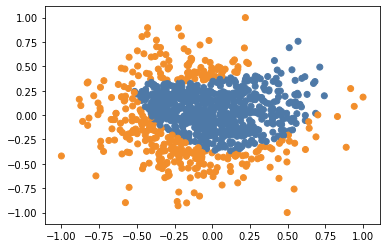

In [8]:
# define symbols
x1, x2 = symbols("x1 x2")

# define expression
a = 1
b = 10
expr = (a - x1)**2 + b*(x2-x1**2)**2

# define mapping from symbols to column of X
col_map = {x1: 0, x2: 1}

# define correlations via covariance matrix
cov = np.array([[3.0, 0.0], [0.0, 3.0]])

dist = [{"column": 0, "dist": "norm"}, {"column": 1, "dist": "norm"}]
X, y_reg, y_prob, y_label = make_tabular_data(
    dist=dist,
    n_samples=1000,
    cov=cov,
    col_map=col_map,
    expr=expr,
    p_thresh=0.5,
    seed=155,
)
df = pd.DataFrame(scaler.fit_transform(X),columns=['d0','d1'])
df['target'] = y_label
plt.scatter(df['d0'],df['d1'],c=df['target'].map(color_map))
# df.to_csv('demo_data/rosenbrock/data.csv',index=False)

## Train classifier

In [9]:
X, y = df[['d0','d1']], df['target'].astype(int)
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)

clf = MLPClassifier(random_state=1, max_iter=1000).fit(x_train, y_train)
clf.score(x_test, y_test)
# now you can save it to a file
with open('demo_data/rosenbrock/model.pkl', 'wb') as f:
    pickle.dump(clf, f)

0.976

In [10]:
pred = clf.predict_proba(X)
pred = (pred[:,0] - pred[:,1]).flatten()

## Train explanations

In [11]:
explainer = shap.KernelExplainer(clf.predict_proba, shap.sample(X,100))
local_attr_list = explainer.shap_values(X,l1_reg=False)
exp = np.array(local_attr_list).squeeze()[0,:,:]

## Sample from distribution to balance number of samples with different prediction probabilities

In [18]:
from scipy import stats

hist,bins = np.histogram(pred)
bin_index = np.digitize(pred,bins)

print("Distribution of data in terms of prediction probability")
print(hist,bins)

from scipy.stats import gaussian_kde
dist_max = np.array(np.max(X,axis=0))
dist_min = np.array(np.min(X,axis=0))
kernel = gaussian_kde(X.to_numpy().T)
max_sample = 600
max_iter = 100

X_sample = []


min_sample = np.min(hist)
n_iter = 0
while n_iter < max_iter and min_sample < max_sample:
    _X = kernel.resample().T
    _pred = clf.predict_proba(_X)
    _pred = (_pred[:,0] - _pred[:,1]).flatten()
    _hist,_bins = np.histogram(_pred,bins)
    bin_index = np.digitize(_pred,bins)
    for h,_h,i in zip(hist,_hist,np.arange(1,len(_hist)+1)):
        _x = _X[bin_index==i,:]
        cond = np.all(_x >= dist_min,1) & np.all(_x <= dist_max,1)
        _x = _x[cond,:]
        if h + len(_x) <= max_sample:
            X_sample.append(_x)
            hist[i-1] += len(_x)
    min_sample = np.min(hist)
    n_iter += 1
    
X_sample = np.concatenate(X_sample)
pred_sample = clf.predict_proba(X_sample)
pred_sample = (pred_sample[:,0] - pred_sample[:,1]).flatten()
local_attr_list = explainer.shap_values(X_sample,l1_reg=False)
exp_sample = np.array(local_attr_list).squeeze()[0,:,:]

print("Distribution of data in terms of prediction probability after sampling")
print(hist,bins)

Distribution of data in terms of prediction probability
[252  25  14  16  12  12  18  24  42 585] [-1.00000000e+00 -8.00001670e-01 -6.00003341e-01 -4.00005011e-01
 -2.00006681e-01 -8.35173534e-06  1.99989978e-01  3.99988308e-01
  5.99986637e-01  7.99984967e-01  9.99983297e-01]



Distribution of data in terms of prediction probability after sampling
[532 599 597 597 599 593 597 596 600 585] [-1.00000000e+00 -8.00001670e-01 -6.00003341e-01 -4.00005011e-01
 -2.00006681e-01 -8.35173534e-06  1.99989978e-01  3.99988308e-01
  5.99986637e-01  7.99984967e-01  9.99983297e-01]


## save everything

In [9]:
directory = 'demo_data/rosenbrock/{}.csv'
np.savetxt(directory.format('exp'), exp, delimiter=",")
np.savetxt(directory.format('pred'), pred, delimiter=",")
np.savetxt(directory.format('pred_sample'), pred_sample, delimiter=",")
np.savetxt(directory.format('X_sample'), X_sample, delimiter=",")
np.savetxt(directory.format('exp_sample'), exp_sample, delimiter=",")
np.savetxt(directory.format('X'), X.to_numpy(), delimiter=",")

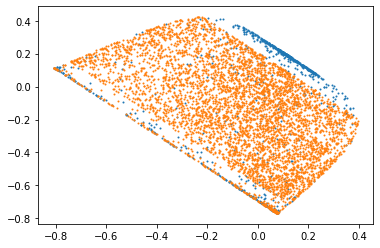

In [16]:
plt.scatter(exp[:,0],exp[:,1],s=1) #blue: explanations on the original points
plt.scatter(exp_sample[:,0],exp_sample[:,1],s=1) #orange: sampled points to increase contiuity of the explanation manifold